##### Copyright 2020 Google

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Hardware grid circuits

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/experiments/qaoa/hardware_grid_circuits"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/ReCirq/blob/master/docs/qaoa/hardware_grid_circuits.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/ReCirq/blob/master/docs/qaoa/hardware_grid_circuits.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/ReCirq/docs/qaoa/hardware_grid_circuits.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

The "hardware grid" problem is defined by a Hamiltonian whose topology matches the hardware graph natively. This permits a simple compilation ("routing") with circuit depth per p-step going like $O(1)$.

## Setup

Install the ReCirq package:

In [2]:
try:
    import recirq
except ImportError:
    !pip install -q git+https://github.com/quantumlib/ReCirq

Now import Cirq, ReCirq and the module dependencies:

In [3]:
import cirq
import recirq

import networkx as nx
import numpy as np
from cirq.contrib.svg import SVGCircuit, circuit_to_svg

from recirq.qaoa.classical_angle_optimization import OptimizationResult
from recirq.qaoa.problems import get_all_hardware_grid_problems

Set the theme colors:

In [4]:
QBLUE = '#1967d2'
QRED = '#ea4335ff'
QGOLD = '#fbbc05ff'

## Create a grid

Here, we'll generate a 3x3 grid with arbitrarily chosen (fake!) beta, gamma parameters. 

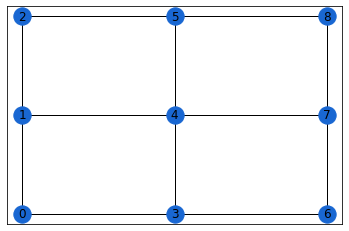

In [5]:
fake_device_graph = nx.grid_2d_graph(3, 3)
fake_device_graph = nx.relabel_nodes(
    fake_device_graph, mapping={(r, c): cirq.GridQubit(r, c)
                                for r, c in fake_device_graph.nodes})

problems = get_all_hardware_grid_problems(fake_device_graph, central_qubit=cirq.GridQubit(1, 1),
                                          n_instances=10, rs=np.random.RandomState(52))
n_qubits = 9
instance_i = 0
problem = problems[n_qubits, instance_i]

optimum = OptimizationResult(p=1, f_val=None, gammas=[0.123], betas=[0.456], min_c=None, max_c=None)
nx.draw_networkx(problem.graph, 
                 pos={i: problem.coordinates[i] for i in range(problem.graph.number_of_nodes())},
                 node_color=QBLUE)

If, however, you've been following along, we can load in the results of `HardwareGridProblemGenerationTask`s for which we've actually pre-computed the optimal angles. TODO: enable.

```
from recirq.qaoa.experiments.problem_generation_tasks import HardwareGridProblemGenerationTask
from recirq.qaoa.experiments.angle_precomputation_tasks import AnglePrecomputationTask

gen_task = HardwareGridProblemGenerationTask(
    dataset_id = '2020-03-19',
    device_name = 'Sycamore23',
    instance_i = 0,
    n_qubits = 5,
)

pre_task = AnglePrecomputationTask(
    dataset_id = '2020-03-23',
    generation_task = gen_task,
    p = 1,
)
print(gen_task)
print(pre_task)
```

```
from recirq.qaoa.experiments.problem_generation_tasks import DEFAULT_BASE_DIR as PGEN_BASE_DIR
from recirq.qaoa.experiments.angle_precomputation_tasks import DEFAULT_BASE_DIR as APRE_BASE_DIR

gen_data = recirq.load(gen_task, base_dir=PGEN_BASE_DIR)
pre_data = recirq.load(pre_task, base_dir=APRE_BASE_DIR)
problem = gen_data['problem']
optimum = pre_data['optimum']
print(optimum)
nx.draw_networkx(problem.graph, 
                 pos={i: problem.coordinates[i] for i in range(problem.graph.number_of_nodes())},
                 node_color=QBLUE
                )
```

## Ansatz

As always, the circuit ansatz involves $|+\rangle$ initialization followed by alternating applications of the problem and driver unitaries. We first construct a highly abstracted circuit with these multi-qubit operations.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


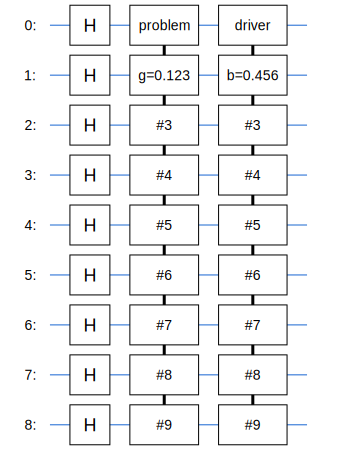

In [6]:
from recirq.qaoa.gates_and_compilation import ProblemUnitary, DriverUnitary
qubits = cirq.LineQubit.range(problem.graph.number_of_nodes())

circuit = cirq.Circuit(
    cirq.H.on_each(qubits),
    ProblemUnitary(problem.graph, gamma=optimum.gammas[0]).on(*qubits),
    DriverUnitary(len(qubits), beta=optimum.betas[0]).on(*qubits)
)
SVGCircuit(circuit)

## Harware topology

We can enact the problem unitary with four entangling layers per p-step. 

 1. Horizontal links from even columns
 2. Horizontal links from odd columns
 3. Vertical links from even rows
 4. Vertical links from odd rows
 
To help the algorithm, we must specify `coordinates` to the compilation routine. This maps from bit indices $\in \{0, 1, \dots n\}$ to `(row, column)` coordinates so the compilation routine can categorize the various links into the above four categories. This is a little roundabout since we'll be mapping to `GridQubit`s, but I'm trying to emphasize the distinction between the problem (which is not related to quantum computing) and the implementation (which is).
 
As always, the driver unitary is nothing more than single-qubit X rotations.

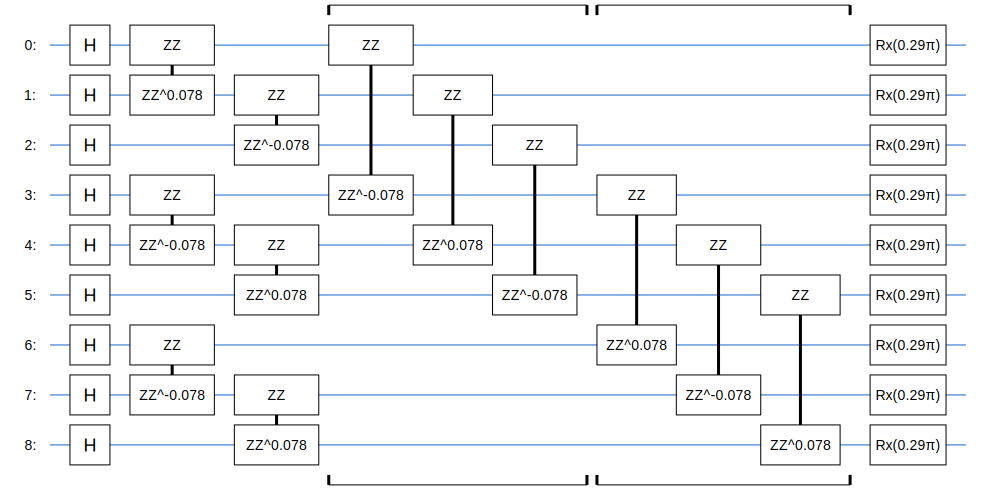

In [7]:
from recirq.qaoa.gates_and_compilation import compile_problem_unitary_to_hardware_graph, \
                                              compile_driver_unitary_to_rx
circuit = compile_problem_unitary_to_hardware_graph(circuit, problem.coordinates)
circuit = compile_driver_unitary_to_rx(circuit)
SVGCircuit(circuit)

## Compilation

To compile $e^{i \gamma w_{ij} Z_i Z_j}$, express the `ZZ` interaction as three rounds of `SYC` gates. We take a brief aside to look at this compilation.

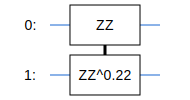

In [8]:
import numpy as np
zz = cirq.Circuit(cirq.ZZ(*qubits[:2])**(2*0.345/np.pi))
SVGCircuit(zz)

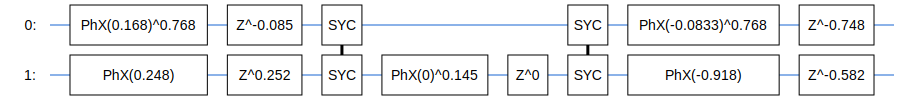

In [9]:
from recirq.qaoa.gates_and_compilation import compile_to_syc
zz = compile_to_syc(zz)
SVGCircuit(zz)

### Function `zz_as_syc` is included for convenience

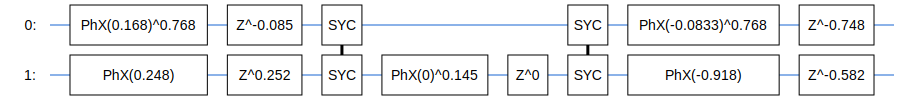

In [10]:
from recirq.qaoa.gates_and_compilation import zz_as_syc
zz = zz_as_syc(0.345, *qubits[:2])
SVGCircuit(zz)

In [11]:
cirq.testing.assert_allclose_up_to_global_phase(
    cirq.Circuit(cirq.ZZ(*qubits[:2])**(2*0.345/np.pi)).unitary(),
    zz_as_syc(0.345, *qubits[:2]).unitary(),
    atol=1e-8
)

In [12]:
cirq.testing.assert_allclose_up_to_global_phase(
    compile_to_syc(cirq.Circuit(cirq.ZZ(*qubits[:2])**(2*0.345/np.pi))).unitary(),
    zz_as_syc(0.345, *qubits[:2]).unitary(),
    atol=1e-8
)

### Structure the gates

Make sure all the gates are well-structured. This means each layer is composed of homogeneous operations which are native to the device.

In [13]:
from recirq.qaoa.circuit_structure import validate_well_structured
_, stats = validate_well_structured(zz)
stats

HomogeneousCircuitStats(num_phx=3, num_z=3, num_syc=2, has_permutation=False, has_measurement=False)

## Compiling to native operations

We use the above compilation of `ZZ` to compile our circuit to native operations. Because our compilation produces well-structured gates and our starting circuit was structured, the resulting circuit is well-structured.

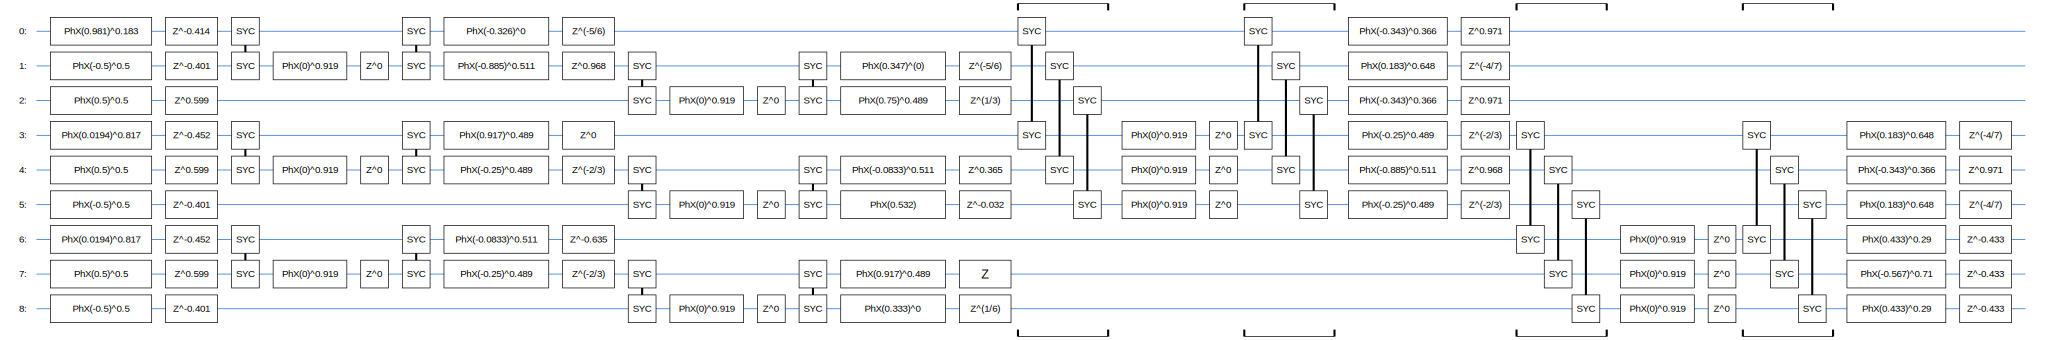

In [14]:
from recirq.qaoa.gates_and_compilation import compile_to_syc
circuit = compile_to_syc(circuit)
SVGCircuit(circuit)

In [15]:
_, stats = validate_well_structured(circuit)
stats

HomogeneousCircuitStats(num_phx=9, num_z=9, num_syc=8, has_permutation=False, has_measurement=False)

## Append measurement

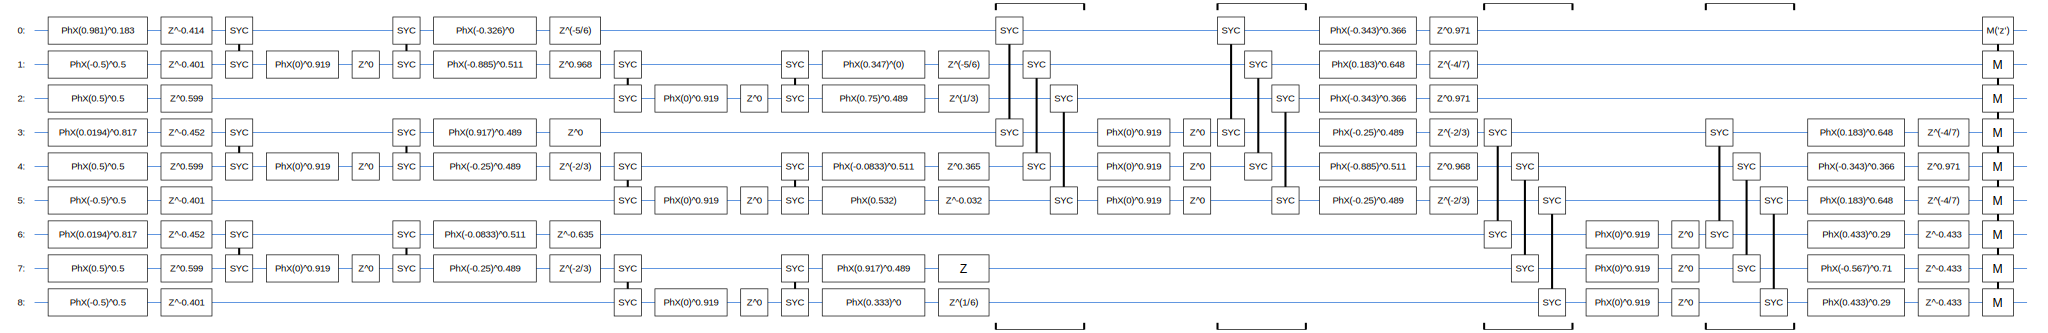

In [16]:
mcircuit = circuit + cirq.measure(*qubits, key='z')
SVGCircuit(mcircuit)

In [17]:
_, stats = validate_well_structured(mcircuit)
stats

HomogeneousCircuitStats(num_phx=9, num_z=9, num_syc=8, has_permutation=False, has_measurement=True)

## Compile out Z's
Z gates commute through SYC so we can remove them. This step is not necessary: the quantum operating system will track the virtual Zs if we don't remove them.

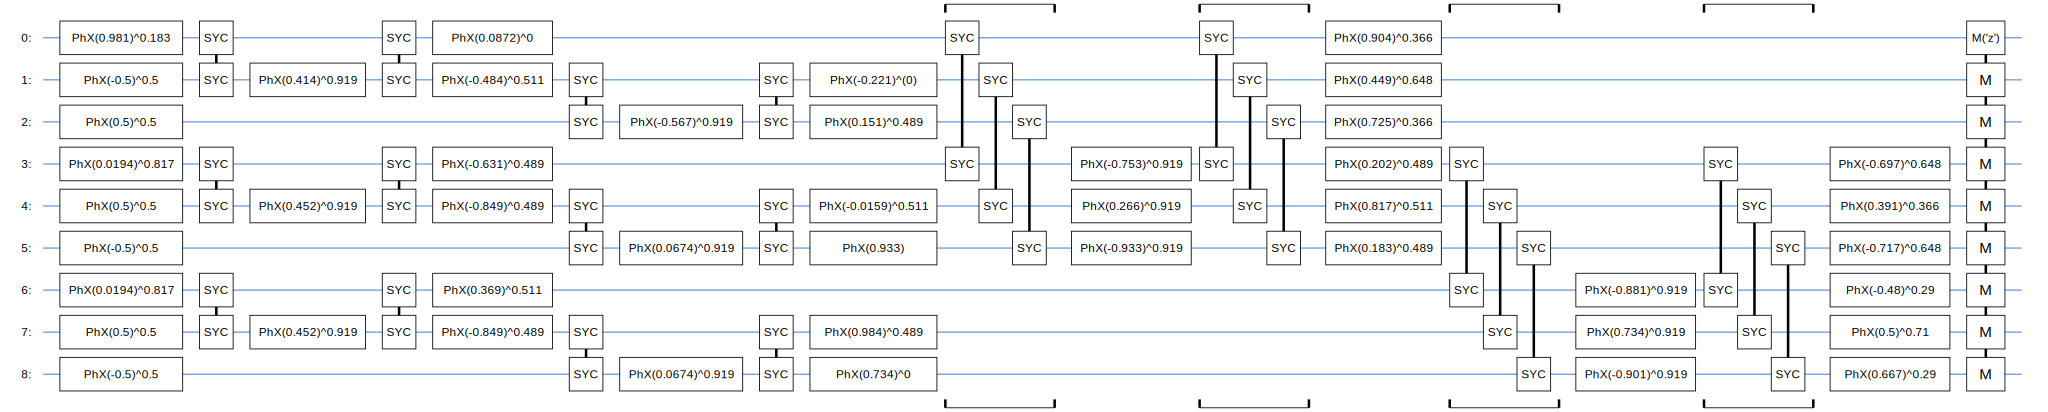

In [18]:
from recirq.qaoa.gates_and_compilation import compile_out_virtual_z
mcircuit = compile_out_virtual_z(mcircuit)
SVGCircuit(mcircuit)

## Compile out negligible gates

We've left several `PhX^0` to keep our circuits structured. As the very last compilation step, we can drop these.

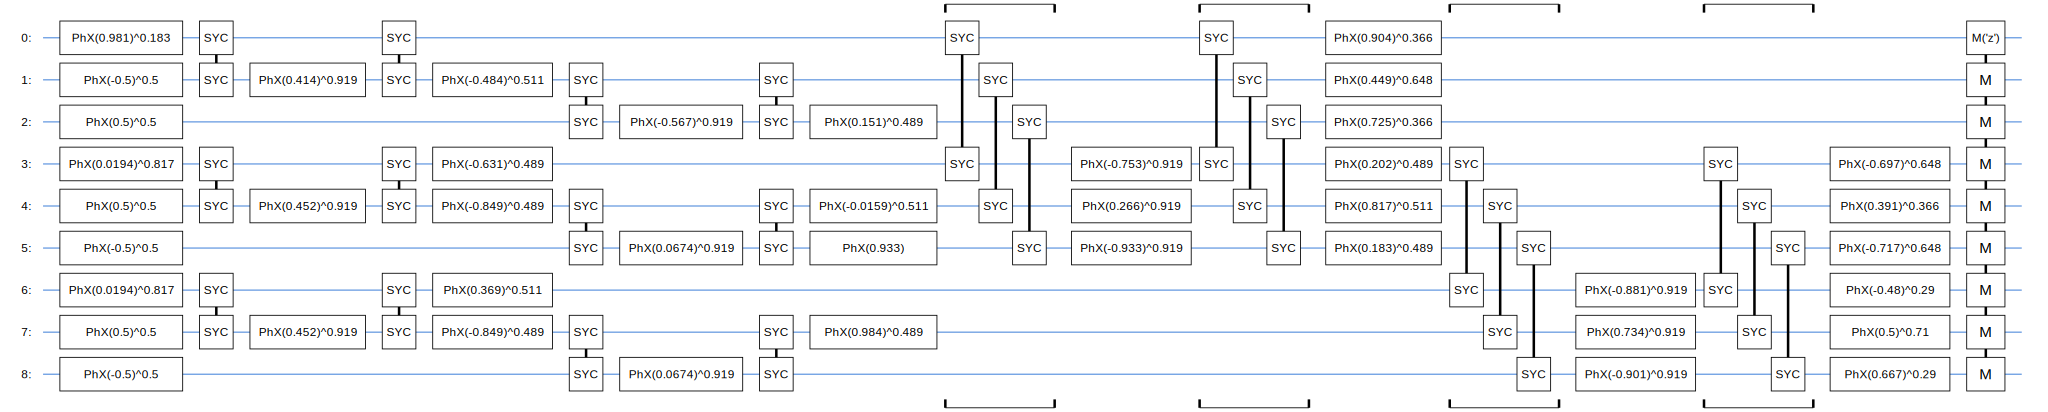

In [19]:
from recirq.qaoa.gates_and_compilation import compile_to_non_negligible
mcircuit = compile_to_non_negligible(mcircuit)
SVGCircuit(mcircuit)

In [20]:
_, stats = validate_well_structured(mcircuit)
stats

HomogeneousCircuitStats(num_phx=9, num_z=0, num_syc=8, has_permutation=False, has_measurement=True)

## Place on device

 - Our problem has integer nodes because it should be specified independently of a quantum implementation
 - Our circuit has LineQubit qubits to emphasize the fact that we can place this circuit in multiple locations on a device
 - Our `coordinates` list was used only as a helper for the compilation
 
We now place the compiled circuit onto a compatible part of the device. Here, we use networkx's subgraph isomorphism routine to find all the possibilities.

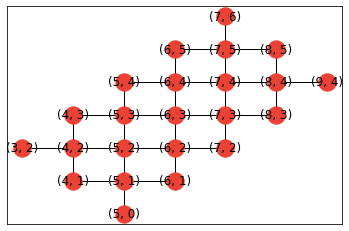

In [21]:
from cirq.contrib.routing import xmon_device_to_graph
device_graph = xmon_device_to_graph(recirq.get_device_obj_by_name('Sycamore23'))
nx.draw_networkx(device_graph, pos={q: (q.row, q.col) for q in device_graph.nodes}, node_color=QRED)

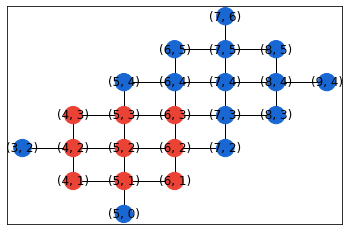

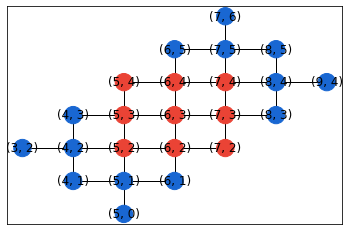

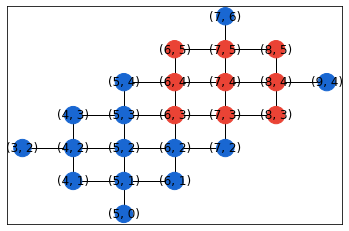

In [22]:
from matplotlib import pyplot as plt
from cirq.contrib.routing import xmon_device_to_graph
device_graph = xmon_device_to_graph(recirq.get_device_obj_by_name('Sycamore23'))
matcher = nx.algorithms.isomorphism.GraphMatcher(device_graph, problem.graph)

# There's a "rotational" freedom which we remove here:
each_set_of_qubits_only_one_subgraph = {}
for q_to_i in matcher.subgraph_isomorphisms_iter():
    each_set_of_qubits_only_one_subgraph[frozenset(q_to_i.keys())] = q_to_i

for q_to_i in each_set_of_qubits_only_one_subgraph.values():
    nx.draw_networkx(device_graph, pos={q: (q.row, q.col) for q in device_graph.nodes},
                     node_color=[QRED if q in q_to_i else QBLUE for q in device_graph.nodes])
    plt.show()


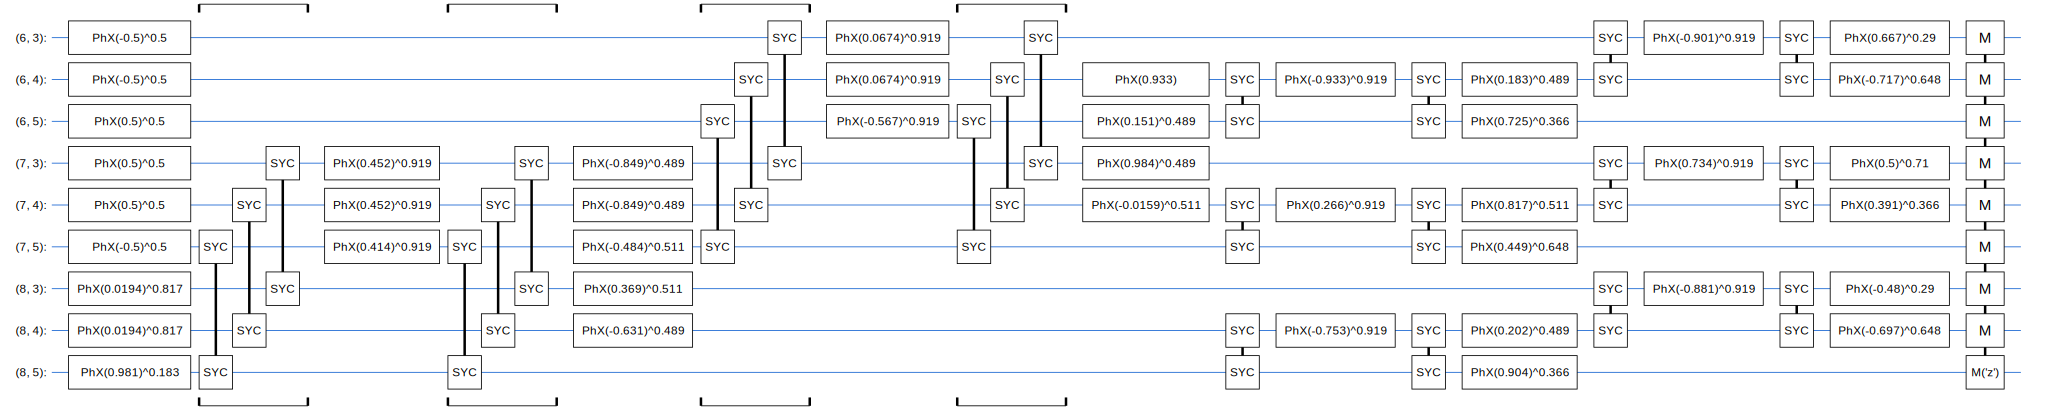

In [23]:
i_to_q = {i: q for q, i in q_to_i.items()}
# Since our nodes are contiguous integers starting from 0, we can flatten into a list
device_qubits = [i_to_q[i] for i in range(len(i_to_q))]
del i_to_q

def _mapq(q):
    return device_qubits[q.x]

mcircuit = mcircuit.transform_qubits(_mapq)
SVGCircuit(mcircuit)

## Problem circuit functions

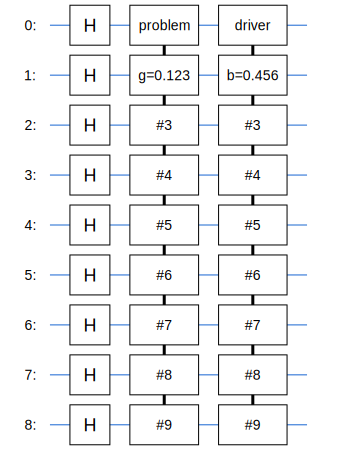

In [24]:
from recirq.qaoa.problem_circuits import get_generic_qaoa_circuit
circuit = get_generic_qaoa_circuit(
    problem_graph=problem.graph, 
    qubits=qubits, 
    gammas=[0.123], 
    betas=[0.456],
)
SVGCircuit(circuit)

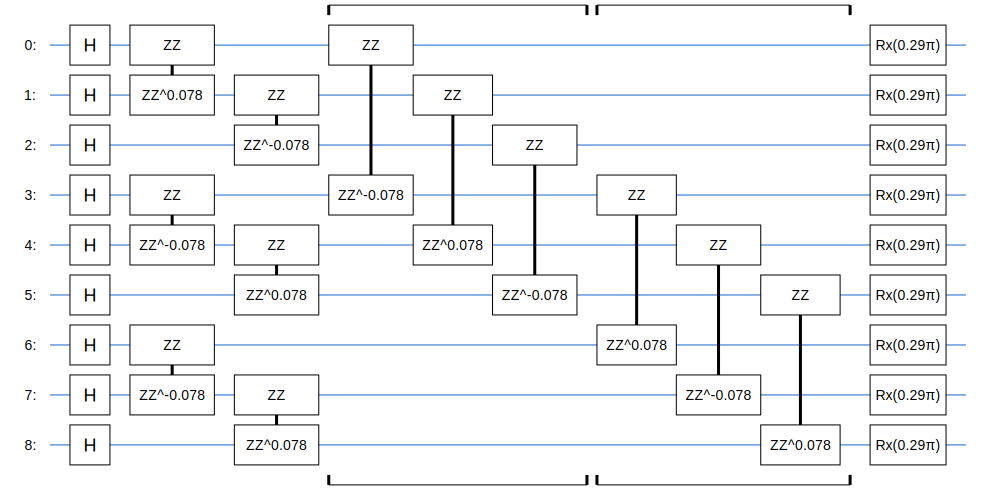

In [25]:
from recirq.qaoa.problem_circuits import get_routed_hardware_grid_circuit
circuit = get_routed_hardware_grid_circuit(
    problem_graph=problem.graph,
    qubits=qubits,
    coordinates=problem.coordinates,
    gammas=[0.123],
    betas=[0.456],
)
SVGCircuit(circuit)

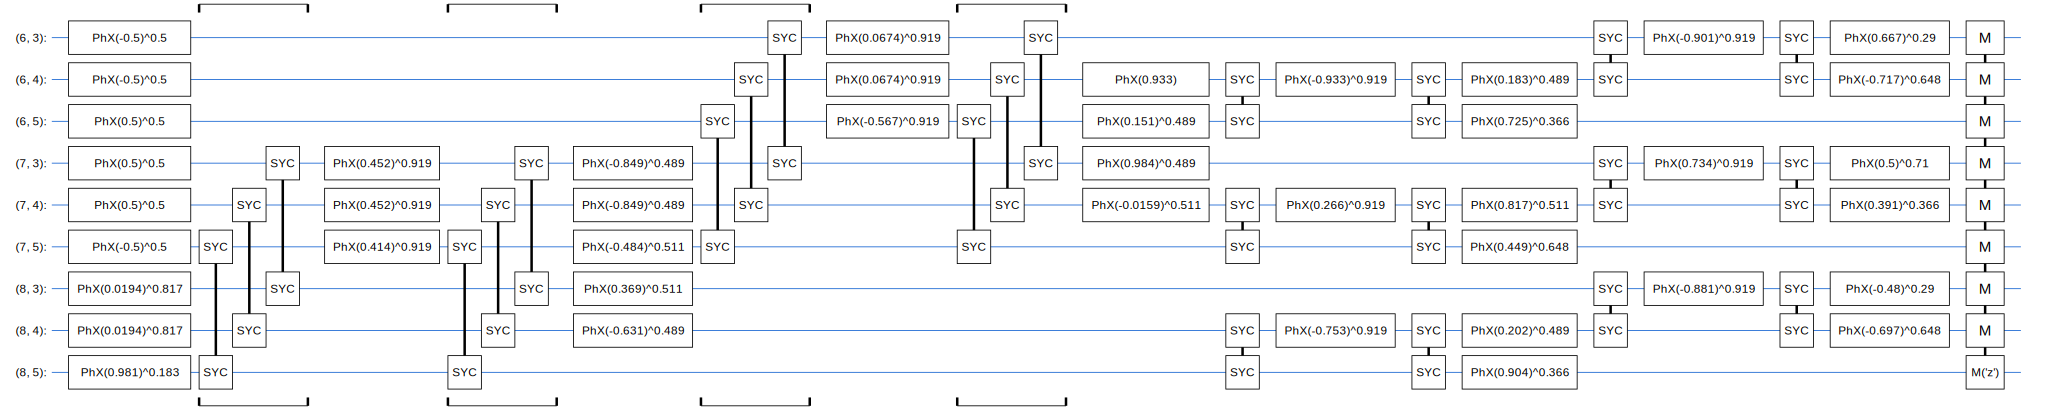

In [26]:
from recirq.qaoa.problem_circuits import get_compiled_hardware_grid_circuit
circuit, qubits = get_compiled_hardware_grid_circuit(
    problem=problem,
    qubits=device_qubits,
    gammas=[0.123],
    betas=[0.456],
)
SVGCircuit(circuit)